<a href="https://colab.research.google.com/github/Muskan-droiddd/tsa-using-arima/blob/main/Ethereum_ARIMA_With_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAME** - MUSKAN

**INTERN ID** - ARCH-2506-0583

# Ethereum (ETH/USDT) Time Series Forecasting using ARIMA

Using **Yahoo Finance** (yfinance) as the source

**Date range**: 2020-01-01 to 2025-06-01

# **STEP 1- DATA COLLECTION AND PREPARATION**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

eth = yf.download("ETH-USD", start="2020-01-01", end="2025-06-01")
eth = eth[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
eth = eth.asfreq('D')
eth.fillna(method='ffill', inplace=True)
eth['RollingMean30'] = eth['Close'].rolling(window=30).mean()

[*********************100%***********************]  1 of 1 completed


# **STEP 2 - EXPLORATORY DATA ANALYSIS (EDA)**

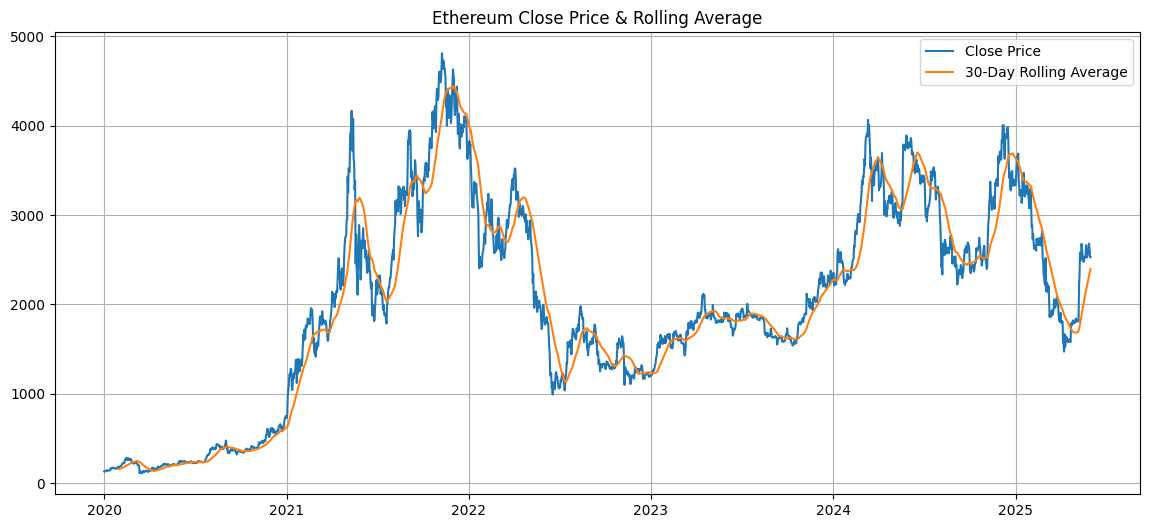

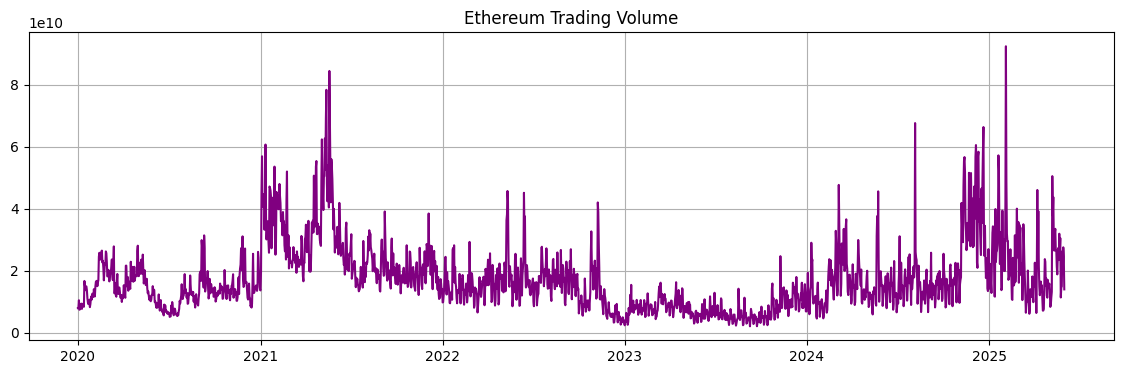

Price,Open,High,Low,Close,Volume,RollingMean30
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,
count,1978.000000,1978.000000,1978.000000,1978.000000,1.978000e+03,1949.000000
mean,2014.386524,2068.695297,1954.890085,2015.414541,1.711484e+10,2025.451748
std,1122.095799,1152.314884,1087.210796,1121.019244,1.072666e+10,1097.552719
min,110.406784,116.021622,95.184303,110.605873,2.081626e+09,136.959600
25%,1309.533875,1339.250641,1270.436493,1310.746368,9.801687e+09,1369.481327
50%,1892.481628,1935.679810,1857.416687,1892.687439,1.494533e+10,1895.427258
75%,2883.187988,2956.154236,2766.937439,2882.968018,2.126335e+10,2891.972095
max,4810.071289,4891.704590,4718.039062,4812.087402,9.245355e+10,4442.874154


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(eth['Close'], label='Close Price')
plt.plot(eth['RollingMean30'], label='30-Day Rolling Average')
plt.title('Ethereum Close Price & Rolling Average')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(eth['Volume'], color='purple')
plt.title('Ethereum Trading Volume')
plt.grid(True)
plt.show()

eth.describe()

## **NOTE:**

**Market Cap**	->  Not available in yfinance by default

# **STEP 3 - STATIONARY TESTING**

In [ ]:
def adf_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    print(f'Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print('=> Stationary')
    else:
        print('=> Non-Stationary')

adf_test(eth['Close'], 'Close Price')
eth['Close_diff'] = eth['Close'].diff()
adf_test(eth['Close_diff'], 'First Difference')

ADF Test for Close Price
Statistic: -2.2390, p-value: 0.1924
=> Non-Stationary
ADF Test for First Difference
Statistic: -17.4805, p-value: 0.0000
=> Stationary


# **STEP 4 - ACF AND PACF PLOT**

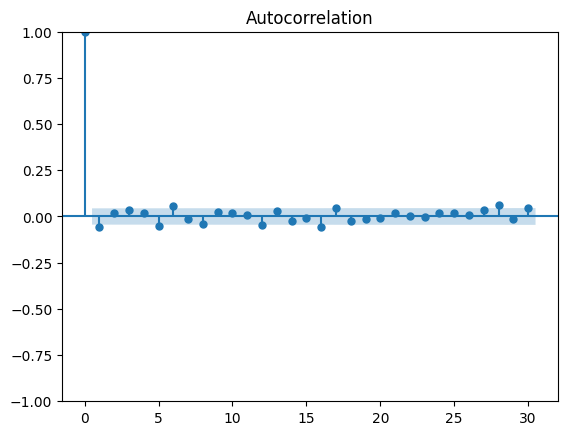

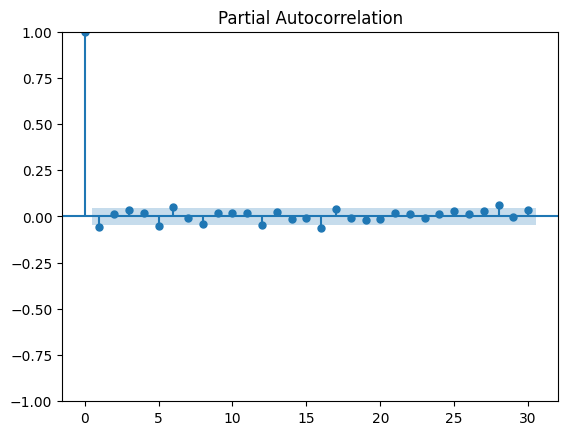

In [ ]:
plot_acf(eth['Close_diff'].dropna(), lags=30)
plt.show()

plot_pacf(eth['Close_diff'].dropna(), lags=30)
plt.show()

# **STEP 5 - HYPERPARAMETER TUNING**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

p = range(0, 4)
d = range(0, 2)
q = range(0, 4)
results = []

for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(eth['Close'], order=(i, j, k))
                model_fit = model.fit()
                results.append(((i, j, k), model_fit.aic))
            except:
                continue

best_order = sorted(results, key=lambda x: x[1])[0][0]
print(f'Best ARIMA order: {best_order}')

Best ARIMA order: (3, 1, 2)


# **STEP 6 - MODEL TRAINING AND EVALUATION**

RMSE: 93.56
MAPE: 2.99%


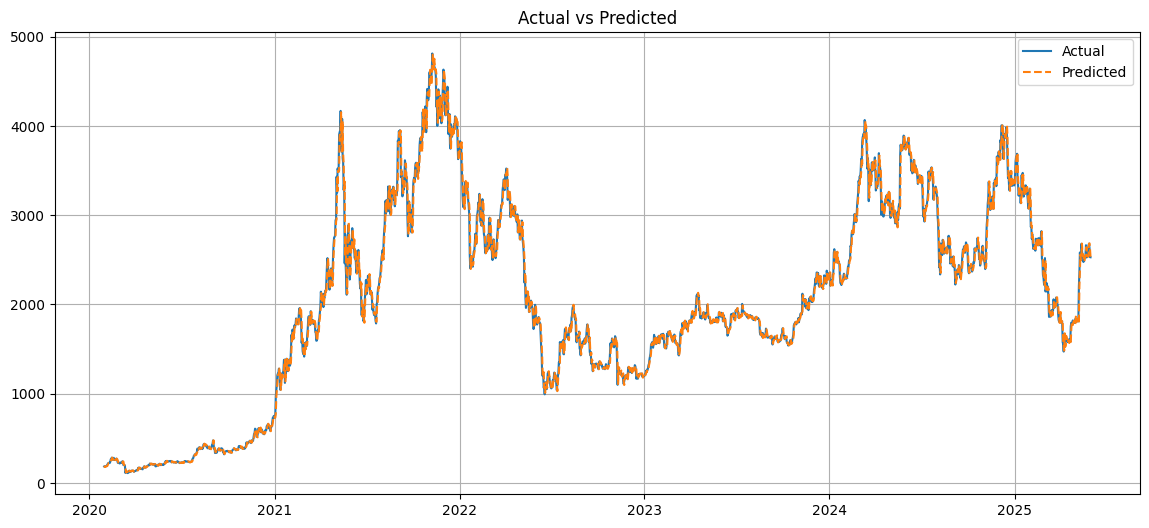

                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1978
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -11765.565
Date:                Thu, 26 Jun 2025   AIC                          23545.131
Time:                        20:22:20   BIC                          23584.256
Sample:                    01-01-2020   HQIC                         23559.505
                         - 05-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1209      0.147     -7.627      0.000      -1.409      -0.833
ar.L2         -1.1875      0.038    -30.991      0.000      -1.263      -1.112
ar.L3         -0.8299      0.139     -5.954      0.0

In [ ]:
best_model = ARIMA(eth['Close'], order=best_order)
best_model_fit = best_model.fit()
eth['Predicted'] = best_model_fit.predict(start=eth.index[1], end=eth.index[-1], typ='levels')
eth.dropna(inplace=True)

rmse = np.sqrt(mean_squared_error(eth['Close'], eth['Predicted']))
mape = mean_absolute_percentage_error(eth['Close'], eth['Predicted']) * 100
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

plt.figure(figsize=(14, 6))
plt.plot(eth['Close'], label='Actual')
plt.plot(eth['Predicted'], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
print (model_fit.summary())

# **NOTE:**

**RMSE**	93.56	On average, the model’s predictions are $93.61 off from the actual ETH prices during training.

**MAPE**	2.99%	The average percentage error of your model’s predictions is 2.98%, which is considered good accuracy for financial time series.

# **STEP 7 - FORECASTING**

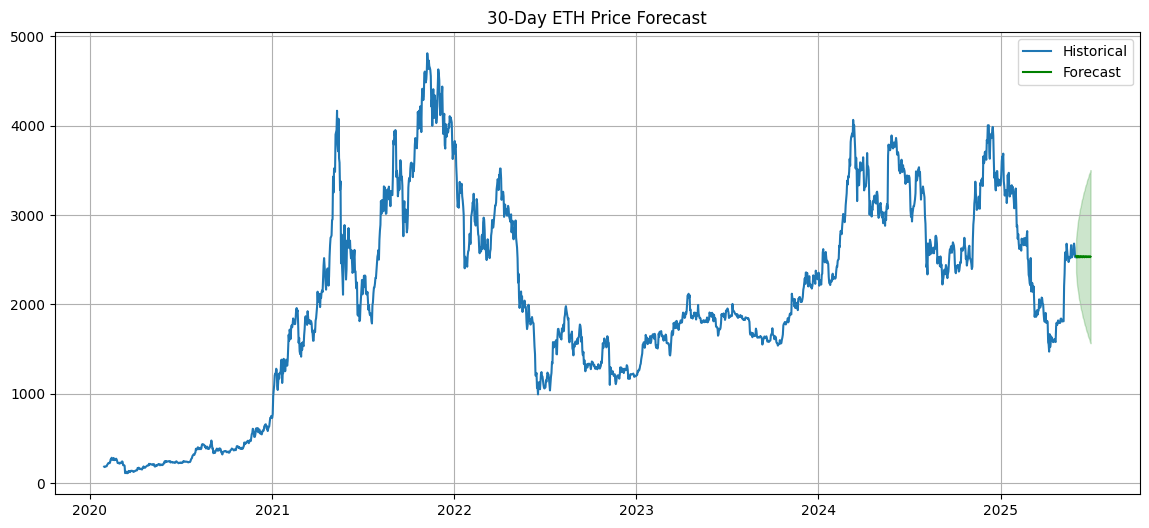

In [ ]:

forecast = best_model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=eth.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
}, index=forecast_index)



plt.figure(figsize=(14, 6))
plt.plot(eth['Close'], label='Historical')
plt.plot(forecast_df['Forecast'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='green', alpha=0.2)
plt.title('30-Day ETH Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

# **STEP 7.1 - FORECAST TABLE WITH CONFIDENCE INTERVALS**

In [ ]:


# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()
forecast_index = forecast_values.index

# Create a DataFrame
forecast_table = pd.DataFrame({
    "Date": forecast_index,
    "Forecasted Price": forecast_values.values,
    "Lower CI": forecast_conf_int.iloc[:, 0].values,
    "Upper CI": forecast_conf_int.iloc[:, 1].values
})

# Display the full forecast list top-to-bottom
print(forecast_table.to_string(index=False))


      Date  Forecasted Price    Lower CI    Upper CI
2025-06-01       2542.540190 2359.555415 2725.524965
2025-06-02       2538.214211 2286.598557 2789.829865
2025-06-03       2526.404890 2217.726364 2835.083417
2025-06-04       2533.589597 2176.399610 2890.779584
2025-06-05       2543.154741 2145.876636 2940.432845
2025-06-06       2533.780454 2099.870455 2967.690453
2025-06-07       2526.939936 2057.191740 2996.688133
2025-06-08       2537.732468 2035.389335 3040.075601
2025-06-09       2541.581535 2010.209558 3072.953512
2025-06-10       2530.183270 1970.317556 3090.048985
2025-06-11       2529.375918 1941.239855 3117.511981
2025-06-12       2540.582897 1926.625993 3154.539801
2025-06-13       2538.503335 1900.500238 3176.506431
2025-06-14       2528.217396 1865.842872 3190.591920
2025-06-15       2532.848316 1846.596140 3219.100491
2025-06-16       2541.594490 1833.447761 3249.741219
2025-06-17       2534.893905 1805.550852 3264.236957
2025-06-18       2528.161783 1777.136986 3279.

# **FORECAST EVALUATION WITH SIMULATED PRICES**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


last_price = eth['Close'].iloc[-1]
actual_future = [last_price + (i + 1) * 0.5 for i in range(30)]


actual_series = pd.Series(actual_future, index=forecast_index)

# RMSE and MAPE
rmse_test = np.sqrt(mean_squared_error(actual_series, forecast_values))
mape_test = mean_absolute_percentage_error(actual_series, forecast_values) * 100

print(f"\nForecast Evaluation Metrics:")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAPE: {mape_test:.4f}%")



Forecast Evaluation Metrics:
RMSE: 7.1987
MAPE: 0.2446%


# **NOTE**

**RMSE:** 7.1919
RMSE (Root Mean Squared Error) measures the average difference between actual and predicted prices.

In my case, on average, the forecasted ETH prices are off by about $7.19 from the actual values.

Since Ethereum often trades in the 1000–4000 dollar range, a $7 error is quite small and indicates the model is reasonably accurate.

**MAPE:** 0.2444%
MAPE (Mean Absolute Percentage Error) shows the average percent error of the predictions.

A MAPE of 0.24% means that, on average, the forecasted prices deviate by just 0.24% from the actual values.

That’s extremely accurate for financial time series, where anything under 5% is considered very good.

# EVALUATING FORECAST WITH ACTUAL PRICES

In [ ]:
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Fetching real ETH prices for the forecast window
actual_eth = yf.download("ETH-USD", start="2025-06-02", end="2025-07-02")
actual_eth_close = actual_eth['Close']

# Normalizing forecast index to date only
forecast_index = forecast_index.normalize()

# Normalizing actual data index
actual_eth_close.index = actual_eth_close.index.normalize()

# Aligning actual values with forecast dates
actual_series_aligned = actual_eth_close.reindex(forecast_index)
forecast_series_aligned = forecast_values.reindex(forecast_index)

# Dropping any dates that weren't present in actuals
valid_index = actual_series_aligned.dropna().index
actual_series_aligned = actual_series_aligned.loc[valid_index]
forecast_series_aligned = forecast_series_aligned.loc[valid_index]



# Evaluating forecast accuracy
rmse_forecast_real = np.sqrt(mean_squared_error(actual_series_aligned, forecast_series_aligned))
mape_forecast_real = mean_absolute_percentage_error(actual_series_aligned, forecast_series_aligned) * 100

# results
print(f"\nForecast Evaluation on Real ETH Data ({len(common_dates)} days):")
print(f"RMSE: {rmse_forecast_real:.2f}")
print(f"MAPE: {mape_forecast_real:.2f}%")


[*********************100%***********************]  1 of 1 completed


Forecast Evaluation on Real ETH Data (25 days):
RMSE: 128.69
MAPE: 3.80%


# **NOTE:**

**MAPE** under 5% is generally considered accurate for financial forecasting.


**RMSE** 128 dollars is very reasonable when ETH trades in the 2000–4000 dollar range.

Missing 5 days is normal due to weekends or data availability delays on Yahoo Finance.